In [13]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
import re  # regex
from PIL import Image, ImageDraw
import random
from scipy.stats import sem, ttest_ind, norm
from scipy.optimize import curve_fit
import seaborn as sns

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample, OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection
from lib.analysis.correlation import FunctionalConnectivityMatrix, StaticFC, DynamicFC

# 2-way ANOVA for medial and lateral PPR vs IPI
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

In [3]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR/"
ppr_coronal_df = data_dir + "export_summary_backup_coronal.csv"
ppr_sagittal_df = data_dir + "export_summary_backup_sagittal.csv"

camera_program = 4
um_per_px = 6.0 #um

# load the CSVs
ppr_coronal_df = pd.read_csv(ppr_coronal_df)
ppr_sagittal_df = pd.read_csv(ppr_sagittal_df)

# add column for Coronal/Sagittal
ppr_coronal_df['Section'] = 'Coronal'
ppr_sagittal_df['Section'] = 'Sagittal'

# combine the dataframes
ppr_df = ppr_coronal_df.append(ppr_sagittal_df)

output_fig_dir = 'P:/John/crossing-paper/input/'
ppr_df

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,trace_non_polyfit,amp_array,Medial/Lateral,Section,Rostral/Caudal
0,1,0.479013,120.492,18.61820,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
1,2,0.330619,120.585,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN
2,1,0.176925,182.307,3.53397,51.660221,53.138122,1_rois pulse2,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
3,2,0.078507,182.489,7.29899,44.112853,28.366771,1_rois pulse2,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN
4,1,0.590332,120.014,12.29530,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,2,5.388340,142.602,5.38834,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,25,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral
1214,1,5.504880,143.043,5.50488,58.472131,43.518033,3_rois pulse1,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Home
1215,2,7.391860,141.078,7.39186,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral
1216,1,7.935810,185.029,7.93581,58.472131,43.518033,3_rois pulse2,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Home


In [15]:
# load PPR catalog
ppr_catalog = data_dir + "ppr_catalog_backup-both.csv"
ppr_catalog_df = pd.read_csv(ppr_catalog)

# only keep zda_file, IPI, and is_single_pulse_control columns
#ppr_catalog_df = ppr_catalog_df[['zda_file', 'IPI', 'is_single_pulse_control']]

# parse slice, location, and recording numbers from zda_file and store in new columns
ppr_catalog_df['zda_id'] = ppr_catalog_df['zda_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
ppr_catalog_df['Slice'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[0]))
ppr_catalog_df['Location'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[1]))
ppr_catalog_df['Recording'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[2]))

# parse date from zda_file column. It is in format "/mm-dd-yy/", use pattern matching to extract date (regex)
# Function to extract date using regex
def extract_date(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{2})', filename)
    if match:
        # remove zero padding from day and month
        m,d,y = match.group(0).split('-')
        d = str(int(d))
        m = str(int(m))
        return f"{m}/{d}/20{y}"
    return None

ppr_catalog_df['Date'] = ppr_catalog_df['zda_file'].apply(extract_date)
ppr_catalog_df


,zda_file,pulse1_start,pulse1_width,pulse2_start,pulse2_width,baseline_start,baseline_width,IPI,is_single_pulse_control,done,Coronal/Sagittal,zda_id,Slice,Location,Recording,Date
0,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01,1,3,1,1/2/2025
1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,NaN,NaN,236,100,60,1,1.0,Coronal,01_03_02,1,3,2,1/2/2025
2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,NaN,NaN,276,100,40,1,1.0,Coronal,01_03_03,1,3,3,1/2/2025
3,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,356.0,70.0,276,180,40,0,1.0,Coronal,01_03_04,1,3,4,1/2/2025
4,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,336,20,356.0,70.0,336,120,10,0,1.0,Coronal,01_03_05,1,3,5,1/2/2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,116,70,NaN,NaN,116,100,120,1,NaN,Sagittal,03_02_22,3,2,22,4/16/2025
670,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,176,70,356.0,70.0,176,280,90,0,NaN,Sagittal,03_02_23,3,2,23,4/16/2025
671,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,176,70,NaN,NaN,176,100,90,1,NaN,Sagittal,03_02_24,3,2,24,4/16/2025
672,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,NaN,NaN,276,100,40,1,NaN,Sagittal,03_02_25,3,2,25,4/16/2025


In [5]:
def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

# merge the two dataframes, using date, slice, location, and recording as keys
ppr_df = ppr_df.merge(ppr_catalog_df, on=['Date', 'Slice', 'Location', 'Recording'])

# drop the zda_file column
ppr_df.drop('zda_file', axis=1, inplace=True)

ppr_df

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,trace_non_polyfit,amp_array,Medial/Lateral,Section,Rostral/Caudal,IPI,is_single_pulse_control,zda_id
0,1,0.479013,120.492,18.61820,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN,60,0,01_03_01
1,2,0.330619,120.585,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN,60,0,01_03_01
2,1,0.176925,182.307,3.53397,51.660221,53.138122,1_rois pulse2,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN,60,0,01_03_01
3,2,0.078507,182.489,7.29899,44.112853,28.366771,1_rois pulse2,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN,60,0,01_03_01
4,1,0.590332,120.014,12.29530,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN,60,1,01_03_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368,2,5.388340,142.602,5.38834,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,25,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral,40,1,03_02_25
2369,1,5.504880,143.043,5.50488,58.472131,43.518033,3_rois pulse1,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Home,40,0,03_02_26
2370,2,7.391860,141.078,7.39186,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral,40,0,03_02_26
2371,1,7.935810,185.029,7.93581,58.472131,43.518033,3_rois pulse2,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Home,40,0,03_02_26


In [6]:
# set matplotlib font to size 22
plt.rcParams.update({'font.size': 22})

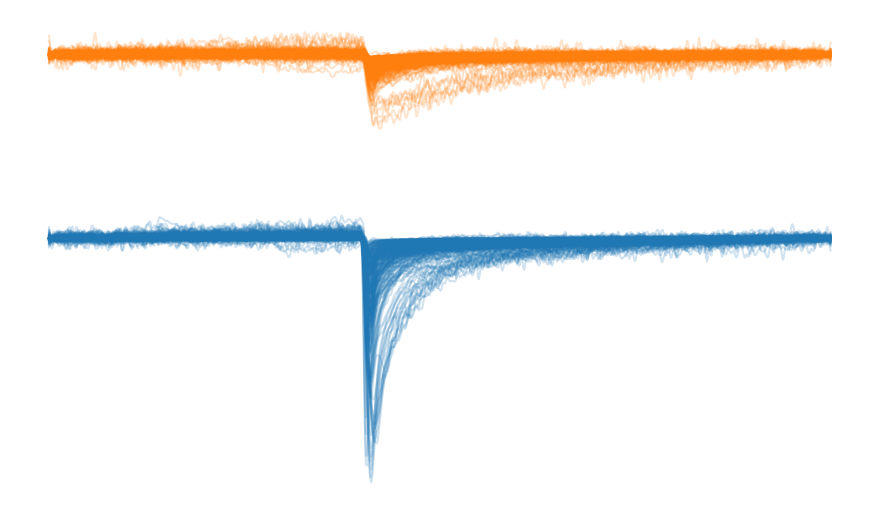

In [7]:
plt.figure(figsize=(10, 6))
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slic_df = date_df[date_df['Slice'] == slic]
        for loc in slic_df['Location'].unique():
            loc_df = slic_df[slic_df['Location'] == loc]
            slic_loc_id = f"{slic}_{loc}"
            for ipi in loc_df['IPI'].unique():
                ipi_df = loc_df[loc_df['IPI'] == ipi]
                #print(f" {date} {slic_loc_id} IPI {ipi}ms")
                
                # for each ROI, there should be two rows in ipi_df, one for control 
                # (is_single_pulse_control = 1) and one for experimental
                # (is_single_pulse_control = 0)
                # the trace files are the same for each ROI, so we can just load them once
                control_df = ipi_df[ipi_df['is_single_pulse_control'] == 1]
                ppr_sub_df = ipi_df[ipi_df['is_single_pulse_control'] == 0]
                
                # load trace and trace_non_polyfit files
                control_trace = read_dat_trace_file(control_df['trace'].values[0])
                control_trace_non_polyfit = read_dat_trace_file(control_df['trace_non_polyfit'].values[0])
                ppr_trace = read_dat_trace_file(ppr_sub_df['trace'].values[0])
                ppr_trace_non_polyfit = read_dat_trace_file(ppr_sub_df['trace_non_polyfit'].values[0])

                # subtract non-polyfit control from ppr
                sub_non_polyfit = ppr_trace_non_polyfit - control_trace_non_polyfit

                # calculate the dist from zero of subtracted trace around the second stim
                trace_sub_dist = sub_non_polyfit[(sub_non_polyfit.index < 356) | (sub_non_polyfit.index > 550)].abs().mean()
                # normalize this to the max of the trace within the the second stim measure window
                trace_sub_dist = trace_sub_dist / sub_non_polyfit[(sub_non_polyfit.index > 356) | (sub_non_polyfit.index < 550)].max()

                # calculate maxAmp of subtracted trace in measure window of second stim (356-450)
                trace_sub_max = sub_non_polyfit[(sub_non_polyfit.index > 356) & (sub_non_polyfit.index < 450)].max()

                # perform baseline correction on control trace 
                first_stim_start = 356 - (ipi * 2)
                exclusion_window = (first_stim_start, first_stim_start + 290)
                bc = BaselineCorrection(control_trace_non_polyfit, exclusion_windows=[exclusion_window])
                control_trace_max = {}
                control_trace_corrected = {}
                for roi in control_trace.columns:
                    if roi == 'Pt':
                        continue
                    control_trace_corrected[roi] = bc.fit_baseline(roi, date+ " " + slic_loc_id + " IPI " + str(ipi) + "ms")
                    # measure MaxAmp of control trace in first stim site measure window

                    control_trace_max[roi] = control_trace_non_polyfit[(control_trace_non_polyfit.index > first_stim_start) 
                                                        & (control_trace_non_polyfit.index < first_stim_start + 104)]['Corrected_'+roi].max()

                # extract first and second maxAmp of ppr_trace. This is the non-subtracted PPR.
                first_maxAmp_non_sub = ppr_trace[(ppr_trace.index > first_stim_start) & 
                                                      (ppr_trace.index < 345)].max()
                second_maxAmp_non_sub = ppr_trace[(ppr_trace.index > 356) & (ppr_trace.index < 550)].max()

                # filter based on trace_sub_dist
                skip_plot = False
                if trace_sub_dist.mean() > 0.18:
                    skip_plot = True

                # plot all traces
                n_rois = len(control_trace.columns) - 1

                for i_roi, roi in enumerate(control_trace.columns):
                    
                    if roi == 'Pt':
                        continue
                    if not skip_plot:
                        t = control_trace.index * 0.5
                        if np.max(sub_non_polyfit[roi][:356]) > 2.5 or np.min(sub_non_polyfit[roi]) < -2.5:
                            continue
                        plt.plot(t, -sub_non_polyfit[roi] - (20 if roi == 'ROI1' else 0), 
                                label='Subtracted', 
                                color='tab:blue' if roi == 'ROI1' else 'tab:orange',
                                alpha=0.2)

#plt.legend(handles=[l1[0], l2[0]], labels=['Home Barrel', 'Neighbor Barrel'], loc='upper right')
plt.tight_layout()

# turn off spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.savefig(output_fig_dir + 'home_neighbor_traces.png')
plt.show()

In [8]:
# restrict to is_single_pulse_control = 0 (to avoid duplicates)
ppr_df = ppr_df[ppr_df['is_single_pulse_control'] == 0]

# and restrict to substring 'pulse1' in "ROI_Set" column (to avoid duplicates)
ppr_df = ppr_df[ppr_df['ROI_Set'].str.contains('pulse1')]

# how many unique date, slice, location combinations are there?
n_unique = len(ppr_df.groupby(['Date', 'Slice', 'Location']).size())
n_unique

29

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_688\2515328437.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Barrel_Type'] = filtered_df['ROI'].apply(lambda x: 'Home' if x == 1 else 'Neighbor')


Significant difference in amp between home and neighbor barrels: p = 0.0000
Significant difference in halfwidth between home and neighbor barrels: p = 0.0000


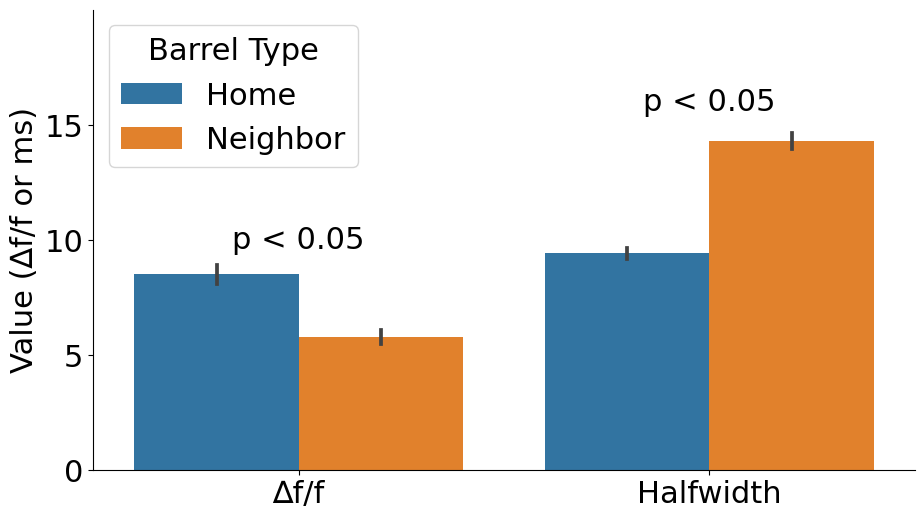

In [9]:
# compare amp, hw, latency for home barrel versus all other barrels
# Assuming `ppr_df` is your DataFrame and contains the necessary columns
# Filter for positive values
filtered_df = ppr_df[(ppr_df['amp'] > 0) & (ppr_df['halfwidth'] > 0)]

# Add a column to distinguish between home barrel and other barrels
filtered_df['Barrel_Type'] = filtered_df['ROI'].apply(lambda x: 'Home' if x == 1 else 'Neighbor')

# Melt the DataFrame for easier plotting with seaborn
melted_df = filtered_df.melt(id_vars=['Barrel_Type'], value_vars=['amp', 'halfwidth',], 
                             var_name='Metric', value_name='Value')

# Create the bar plot
plt.figure(figsize=(10, 6))
# with blue and orange colors for home and neighbor barrels respectively
sns.set_palette(['tab:blue', 'tab:orange'])
sns.barplot(data=melted_df, x='Metric', y='Value', hue='Barrel_Type', ci=68)

# Customize the plot
#plt.title('Comparison of Amp, HW, and Latency: Home Barrel vs Other Barrels')
plt.legend(title='Barrel Type')
plt.tight_layout()

# significance testing
amp_home = filtered_df[filtered_df['Barrel_Type'] == 'Home']['amp']
amp_neighbor = filtered_df[filtered_df['Barrel_Type'] == 'Neighbor']['amp']
amp_ttest = ttest_ind(amp_home, amp_neighbor, equal_var=False)
amp_ttest_p = amp_ttest.pvalue
if amp_ttest_p < 0.05:
    print(f"Significant difference in amp between home and neighbor barrels: p = {amp_ttest_p:.4f}")
    # add p < 0.05 label to the plot
    plt.text(0.25, 0.5, f"p < 0.05", ha='center', va='center', transform=plt.gca().transAxes, fontsize=22, color='black')

hw_home = filtered_df[filtered_df['Barrel_Type'] == 'Home']['halfwidth']
hw_neighbor = filtered_df[filtered_df['Barrel_Type'] == 'Neighbor']['halfwidth']
hw_ttest = ttest_ind(hw_home, hw_neighbor, equal_var=False)
hw_ttest_p = hw_ttest.pvalue
if hw_ttest_p < 0.05:
    print(f"Significant difference in halfwidth between home and neighbor barrels: p = {hw_ttest_p:.4f}")
    # add p < 0.05 label to the plot
    plt.text(0.75, 0.80, f"p < 0.05", ha='center', va='center', transform=plt.gca().transAxes, fontsize=22, color='black')

plt.ylabel('Value (∆f/f or ms)')
plt.ylim(0, 20)
plt.xticks([0, 1])
# set x tick labels 
plt.gca().set_xticklabels(['∆f/f', 'Halfwidth'], fontsize=22)
plt.xlabel('')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# set y label ticks to be 0, 5, 10, 15
plt.gca().set_yticks([0, 5, 10, 15])

# Show the plot
plt.savefig(output_fig_dir + 'home_vs_neighbor_barrels.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1
ppr_df = ppr_df[ppr_df['is_single_pulse_control'] == 0]
ppr_df = ppr_df[ppr_df['ROI_Set'].str.contains('pulse1')]

# Restrict to neighbor barrels (ROI > 1)
ppr_df = ppr_df[ppr_df['ROI'] > 1]

# barplot of hw, lat, and amp for rostral, caudal, medial, and lateral barrels

barrel_df = ppr_df.copy()
barrel_df.loc[barrel_df['Section'] == 'Sagittal', 'Barrel_Type'] = barrel_df[barrel_df['Section'] == 'Sagittal']['Rostral/Caudal']
barrel_df.loc[barrel_df['Section'] == 'Coronal', 'Barrel_Type'] = barrel_df[barrel_df['Section'] == 'Coronal']['Medial/Lateral']
barrel_df 

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,...,trace,trace_non_polyfit,amp_array,Medial/Lateral,Section,Rostral/Caudal,IPI,is_single_pulse_control,zda_id,Barrel_Type
1,2,0.330619,120.5850,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN,60,0,01_03_01,Lateral
9,2,0.122340,142.7130,10.10660,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN,40,0,01_03_04,Lateral
13,2,0.000000,336.0000,-361.92500,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN,10,0,01_03_05,Lateral
21,2,0.362766,51.7331,30.18870,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN,130,0,01_03_08,Lateral
27,2,0.135539,72.8248,16.74330,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN,110,0,01_03_10,Lateral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,2,9.340670,133.1430,9.34067,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral,50,0,03_02_17,Rostral
2350,2,2.474920,154.3370,2.47492,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral,30,0,03_02_19,Rostral
2356,2,8.431020,62.8895,8.43102,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral,120,0,03_02_21,Rostral
2362,2,15.102300,90.2166,15.10230,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral,90,0,03_02_23,Rostral


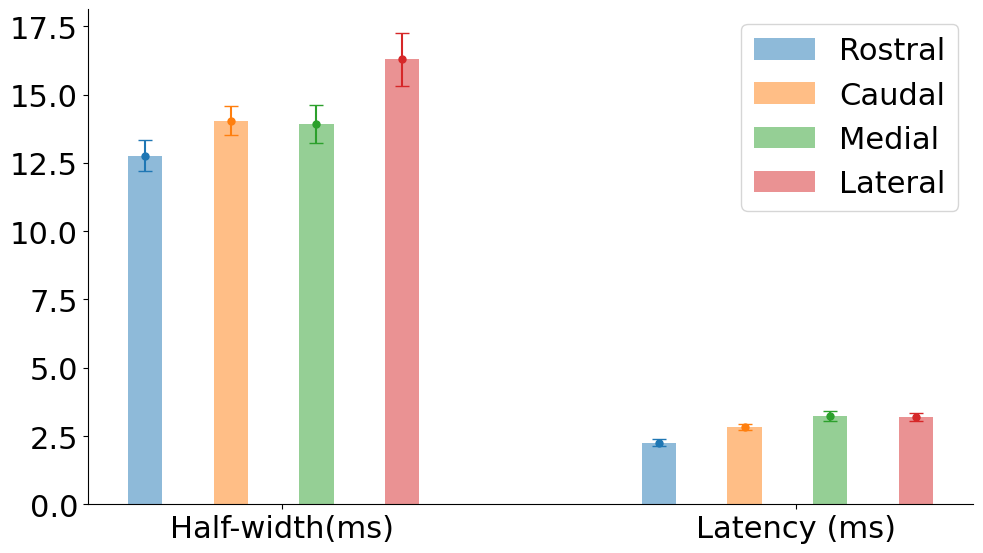

In [11]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1

barrel_df['Barrel_Type'] = barrel_df['Barrel_Type'].astype('category')
barrel_df['Barrel_Type'].cat.set_categories(['Rostral', 'Caudal', 'Medial', 'Lateral'], inplace=True)
barrel_df['latency'] = barrel_df['latency'] % 10
plt.figure(figsize=(10, 6))
# don't use seaborn, use matplotlib
# and plot only positive values
for metric in ['halfwidth', 'latency']:
    handles = []
    for barrel_type in barrel_df['Barrel_Type'].cat.categories:
        # filter for positive values
        df = barrel_df.copy()
        df = df[df['Barrel_Type'] == barrel_type]
        df = df[df[metric] > 0]

        color = 'tab:blue' if barrel_type == 'Rostral' else 'tab:orange' if barrel_type == 'Caudal' else 'tab:green' if barrel_type == 'Medial' else 'tab:red' if barrel_type == 'Lateral' else 'tab:gray'

        x_space = ['amp', 'halfwidth', 'latency'].index(metric) * 1.5 + \
            (0.25 if barrel_type == 'Rostral' else .5 if barrel_type == 'Caudal' else .75 if barrel_type == 'Medial' else 1)
        
        l1 = plt.bar(x_space, df[metric].mean(), color=color, alpha=0.5, width=0.1, label=barrel_type)
        handles.append(l1)

        plt.errorbar(x_space, df[metric].mean(), yerr=sem(df[metric]), fmt='o', color=color, capsize=5, markersize=5)

plt.xticks([2.15, 3.65], ['Half-width(ms)', 'Latency (ms)'], fontsize=22)
# Customize the plot
plt.legend(handles=handles, loc='upper right')
plt.tight_layout()

# set spines to be invisible
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig(output_fig_dir + 'rostro_caudal_medial_lateral_barrels.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
# 2-way ANOVA for rostral and caudal PPR vs IPI (sagittal sections)
model = ols('PPR ~ IPI + C(Rostral_Caudal) + IPI:C(Rostral_Caudal)', 
                data=ppr_df[(ppr_df['Rostral_Caudal'] != 'Home') & (ppr_df['Section'] == 'Sagittal')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

KeyError: 'Rostral_Caudal'

In [ ]:
# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)
model = ols('PPR ~ IPI + C(Section) + IPI:C(Section)', 
                data=ppr_df[(ppr_df['Medial_Lateral'] != 'Home') & (ppr_df['Rostral_Caudal'] != 'Home')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Section),1.206759,1.0,0.901184,0.342984
IPI,1.829139,1.0,1.365965,0.243138
IPI:C(Section),2.034233,1.0,1.519125,0.218409
Residual,590.535086,441.0,NaN,NaN


In [ ]:
# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)
model = ols('PPR ~ C(Section)', 
                data=ppr_df[(ppr_df['IPI'] == 10)]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Section),7.97932,1.0,1.190514,0.280256
Residual,348.52560,52.0,NaN,NaN


## 